A model for foreign 90 FAs  
- ANN : minibatch, epoch
- Boosting : GBR early stopping

### Settings

In [58]:
!pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D   
import matplotlib.ticker as mticker
from scipy.stats import reciprocal
%matplotlib inline

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score  # accuracy, coefficient of determination

import pandas as pd
import numpy as np
import random as rn

import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Delete Warning Message
import logging
import warnings
logging.disable(30)
warnings.filterwarnings(action='ignore')
from copy import deepcopy

In [60]:
rn.seed(42)
np.random.seed(42)   # np.random 모듈의 추출결과 고정하기 위해..

### 1. Load Data

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
df = pd.read_csv('/content/drive/MyDrive/Flyash/foreign_flyash.csv')  # have to change path
df = df.drop("ID", axis=1)

In [63]:
columns = list(df.columns)
columns[6] = 'Aluminosilicate Glass'
df.columns = columns

In [64]:
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,Aluminosilicate Glass
0,29.5,1.1,4.6,53.8,0.7,1.85,72.65
1,20.7,10.2,7.1,51.4,3.0,1.26,78.07
2,17.8,10.6,7.6,55.3,2.3,1.02,73.29
3,22.8,11.9,3.8,51.6,2.0,0.73,73.81
4,21.6,13.6,4.3,42.9,2.5,8.36,84.90
...,...,...,...,...,...,...,...
85,26.0,2.4,8.6,53.2,1.6,2.28,84.00
86,17.9,27.3,8.4,28.5,3.8,0.86,62.00
87,25.9,2.3,8.8,48.2,1.5,2.21,72.00
88,33.4,2.4,6.4,50.8,0.8,0.86,73.00


In [65]:
features = np.array(df.columns)

In [66]:
df.iloc[:,6].describe()

count    90.000000
mean     68.426444
std      15.357767
min      26.600000
25%      60.350000
50%      72.365000
75%      78.052500
max      92.500000
Name: Aluminosilicate Glass, dtype: float64

### 2. Deeply Check Data

In [67]:
features = [u'Al\u2082O\u2083', 'CaO', u'Fe\u2082O\u2083', u'SiO\u2082O', 'MgO', u'Na\u2082O+0.658K\u2082O', 'Aluminosilicate glass']

In [68]:
mpl.matplotlib_fname()

'/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/matplotlibrc'

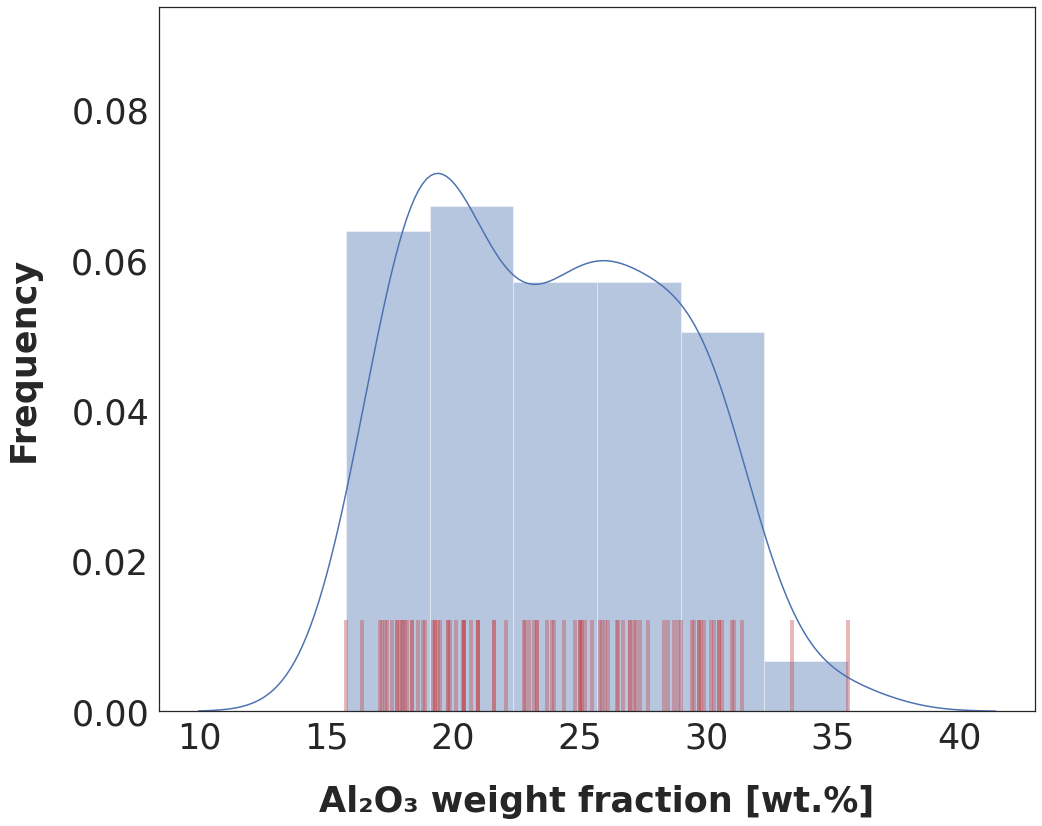

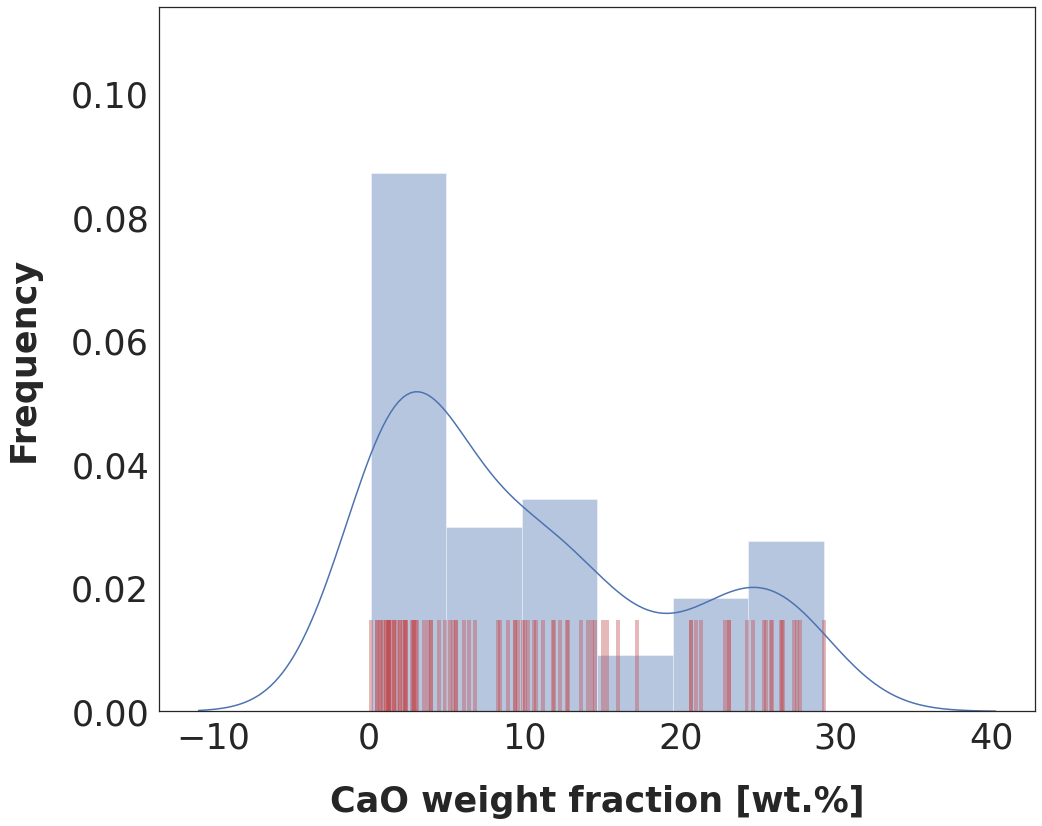

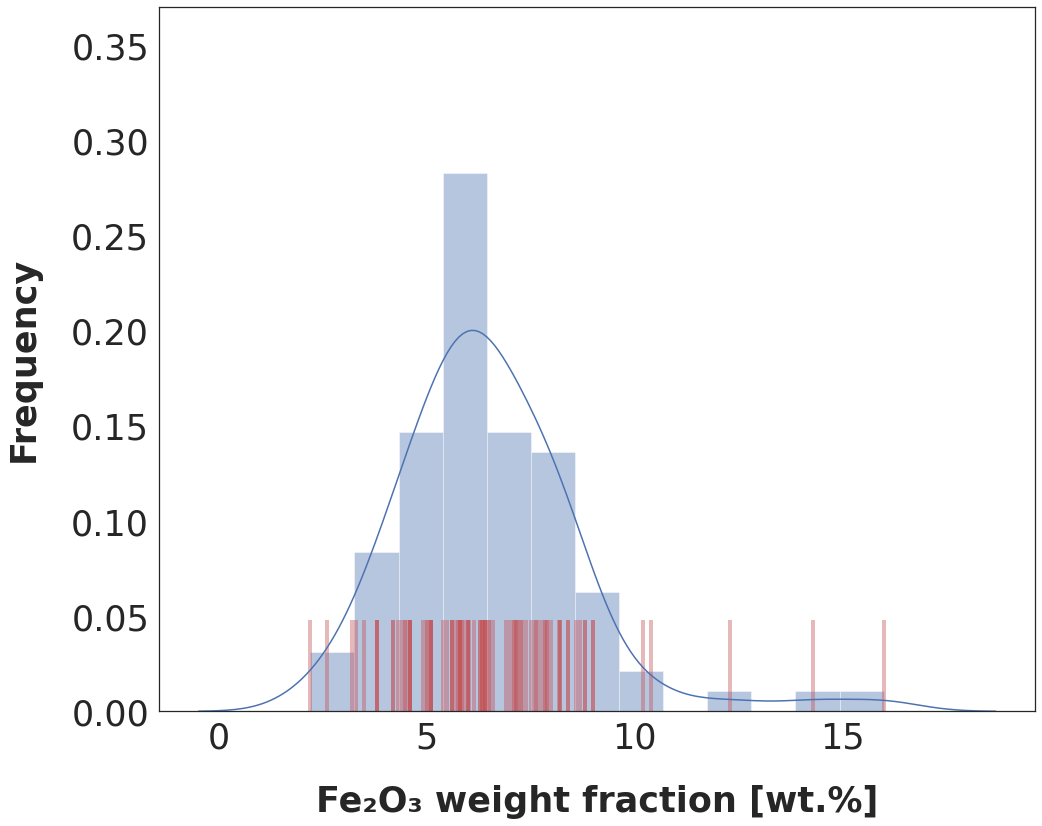

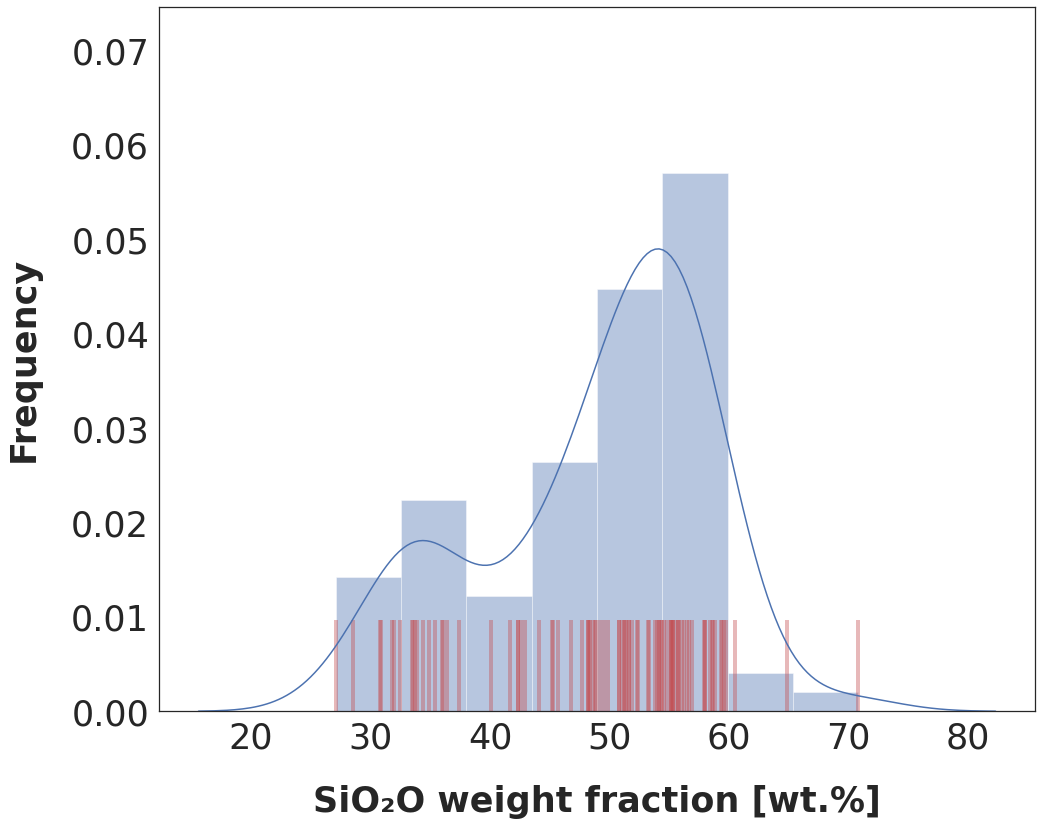

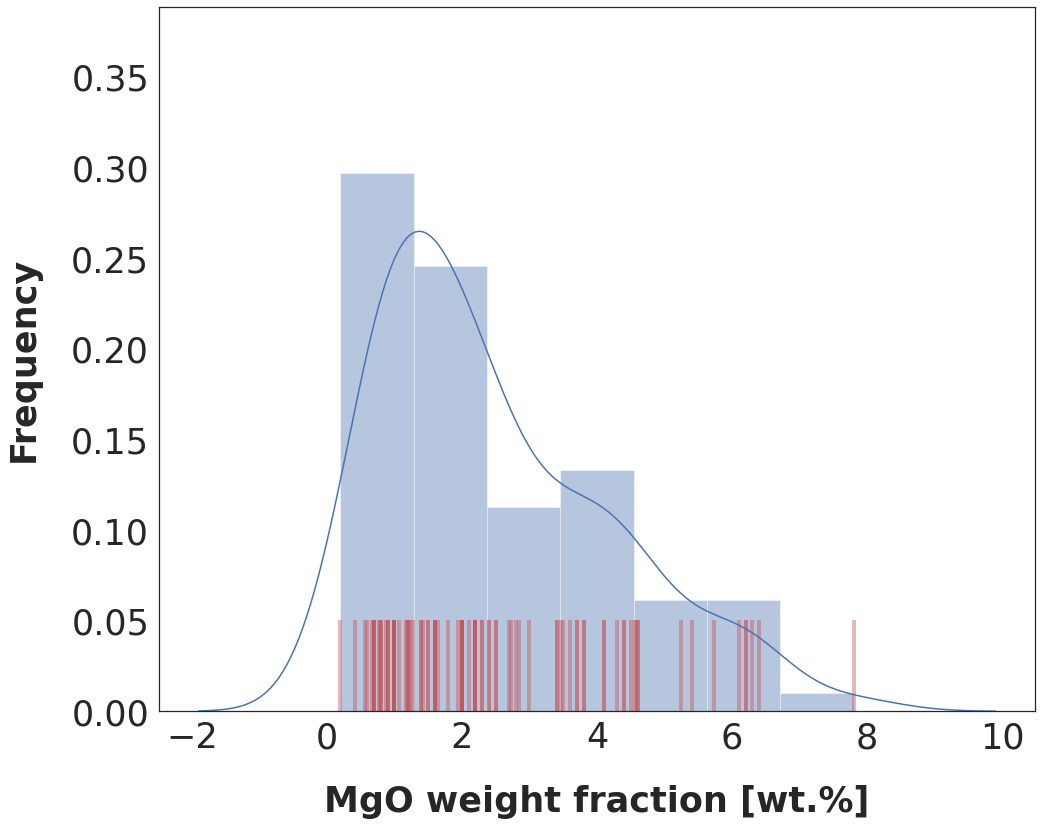

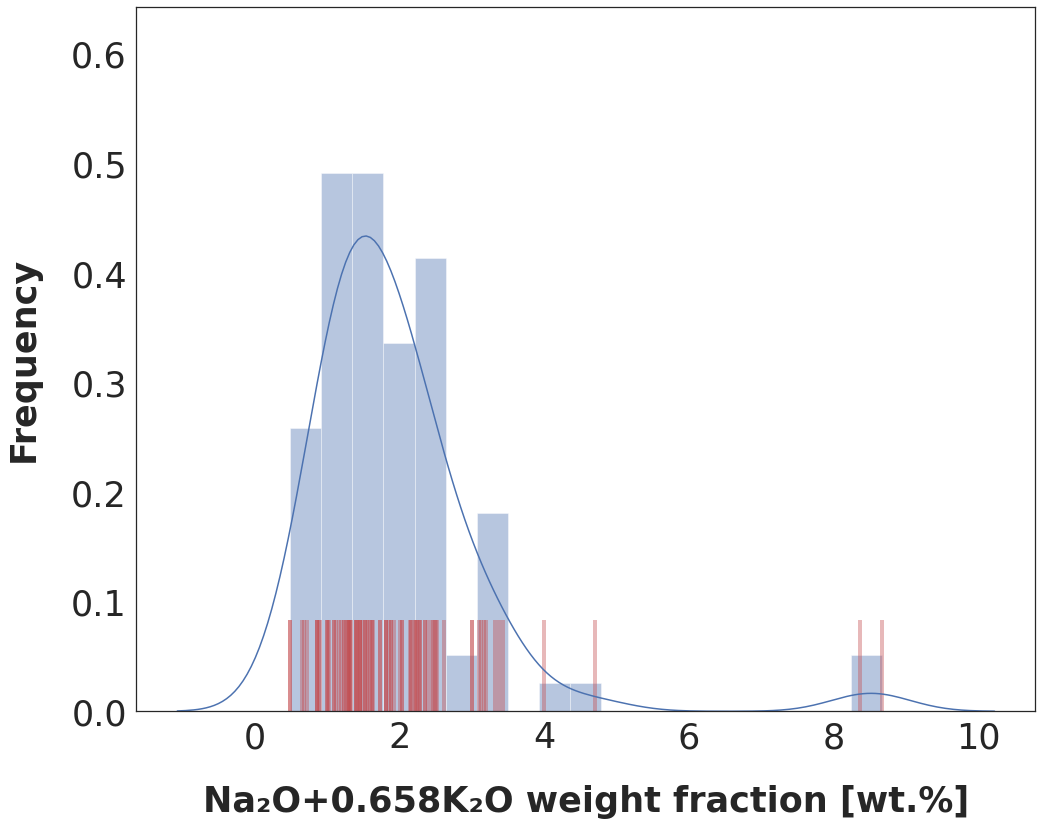

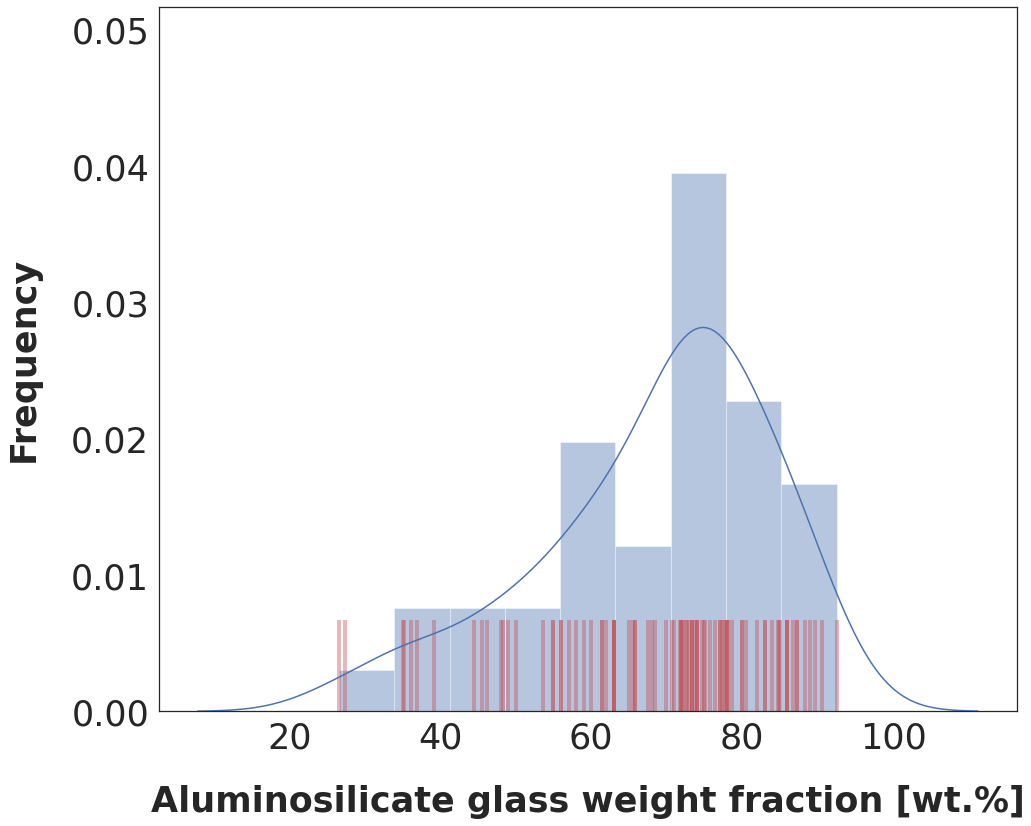

In [69]:
var=np.arange(1,len(features)+1)
var

figsize(15,12)

for i in var:
    # plt.subplot(3,3,i)
    sns.set(font_scale=2)
    sns.set_style('white')

    SMALL_SIZE = 35
    MEDIUM_SIZE = 35
    PADDING_SIZE = 30

    plt.rc('font', family='sans-serif')
    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    # plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    p = sns.distplot(df.iloc[:,(i-1)], rug=True,
                     rug_kws = {'color':'r', 'alpha':0.4, 'linewidth':4, 'height':0.13})      # bins = n_samples, dist
    
    


    p.set_xlabel(f'{features[i-1]} weight fraction [wt.%]', fontsize=MEDIUM_SIZE, labelpad=PADDING_SIZE, fontweight='bold')
    p.set_ylabel('Frequency', fontsize=MEDIUM_SIZE, labelpad=PADDING_SIZE, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/Flyash/Figure/Fig1/{i}_{features[i-1]}.png')
    plt.show()

# plt.savefig('./distrb_input_feature.png')

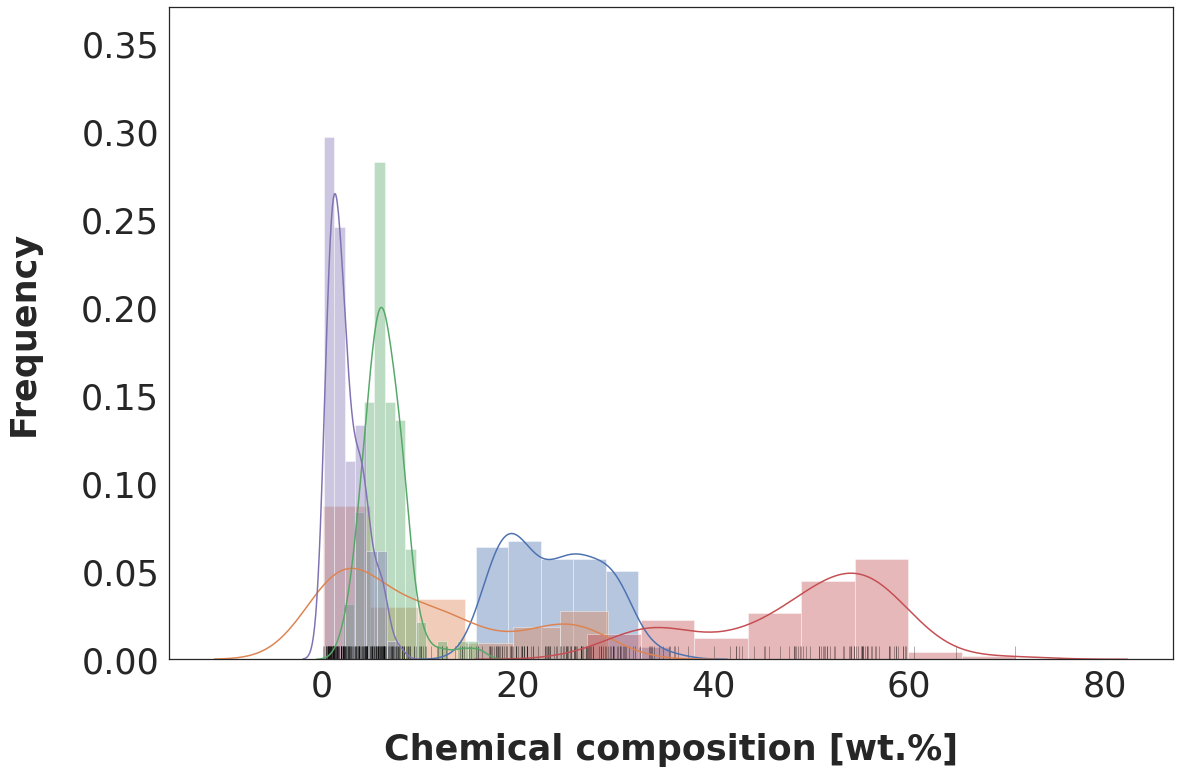

In [70]:
var=np.arange(1,len(df.columns)-1)
var

figsize(18,12)

for i in var:
    # plt.subplot(3,3,i)
    sns.set(font_scale=2)
    sns.set_style('white')

    SMALL_SIZE = 35
    MEDIUM_SIZE = 35
    PADDING_SIZE = 30

    plt.rc('font', family='sans-serif')
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

    p = sns.distplot(df.iloc[:,(i-1)],rug=True,
                     rug_kws = {'color':'black', 'alpha':0.3, 'linewidth':1, 'height':0.02})
    
    
    # p.set_title(features[i-1], fontsize=30, pad=20)
    p.set_xlabel(f'Chemical composition [wt.%]', fontsize=MEDIUM_SIZE, labelpad=PADDING_SIZE, fontweight='bold')
    p.set_ylabel('Frequency', fontsize=MEDIUM_SIZE, labelpad=PADDING_SIZE+10, fontweight='bold')
    plt.savefig(f'{features[i-1]}.png')
    if i ==6:
      plt.savefig(f'/content/drive/MyDrive/Flyash/Figure/Fig2_before.png')
      # plt.show()

# plt.savefig('./distrb_input_feature.png')

### 3. Data Preprocessing (Stratified Sampling)

1    19
3    19
5    18
2    17
4    17
Name: aluminosilicate_cat, dtype: int64


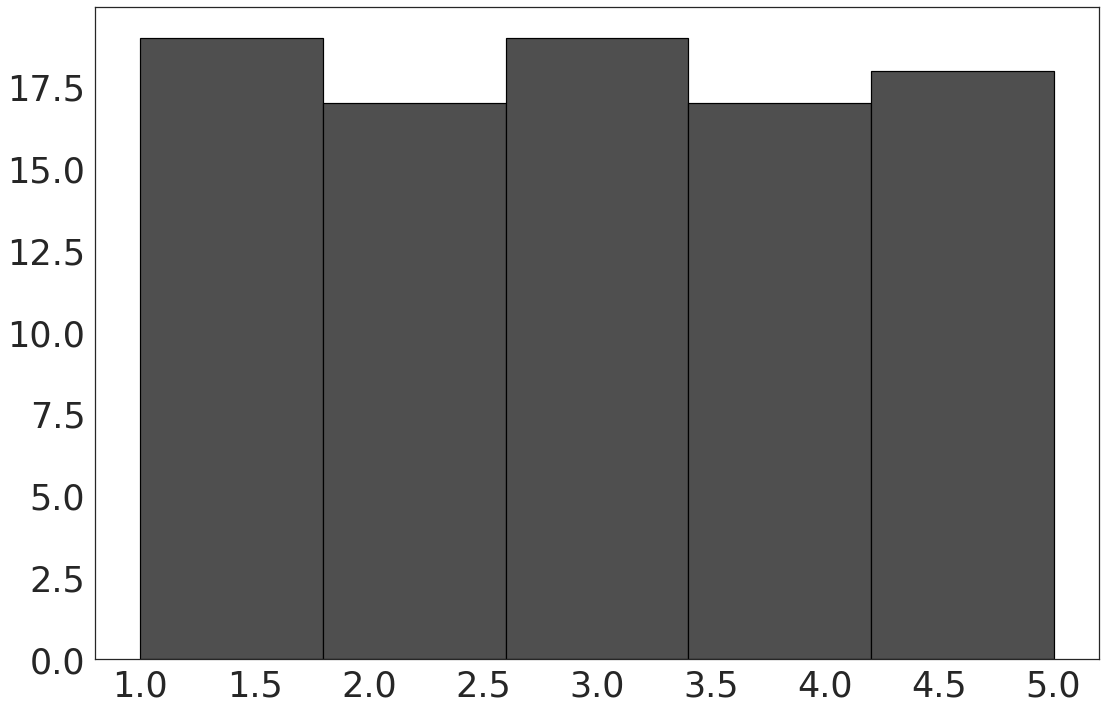

In [71]:
dist = [0.,
        df['Aluminosilicate Glass'].quantile(0.2),
        df['Aluminosilicate Glass'].quantile(0.4),
        df['Aluminosilicate Glass'].quantile(0.6),
        df['Aluminosilicate Glass'].quantile(0.8),
        np.inf]

df['aluminosilicate_cat'] = pd.cut(df['Aluminosilicate Glass'], 
                                     bins=dist, 
                                     labels=[1,2,3,4,5])
print(df['aluminosilicate_cat'].value_counts())
df['aluminosilicate_cat'].hist(color='#4F4F4F', grid=False, bins=5, edgecolor='black', linewidth=1.2)

In [72]:
df['Aluminosilicate Glass'].quantile(0.2), df['Aluminosilicate Glass'].quantile(0.4), df['Aluminosilicate Glass'].quantile(0.6), df['Aluminosilicate Glass'].quantile(0.8) 

(56.0, 68.234, 74.0, 80.80000000000001)

In [73]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.145, random_state=42)

for train_idx, test_idx in split.split(df, df["aluminosilicate_cat"]):
    strat_train = df.loc[train_idx]
    strat_test = df.loc[test_idx]

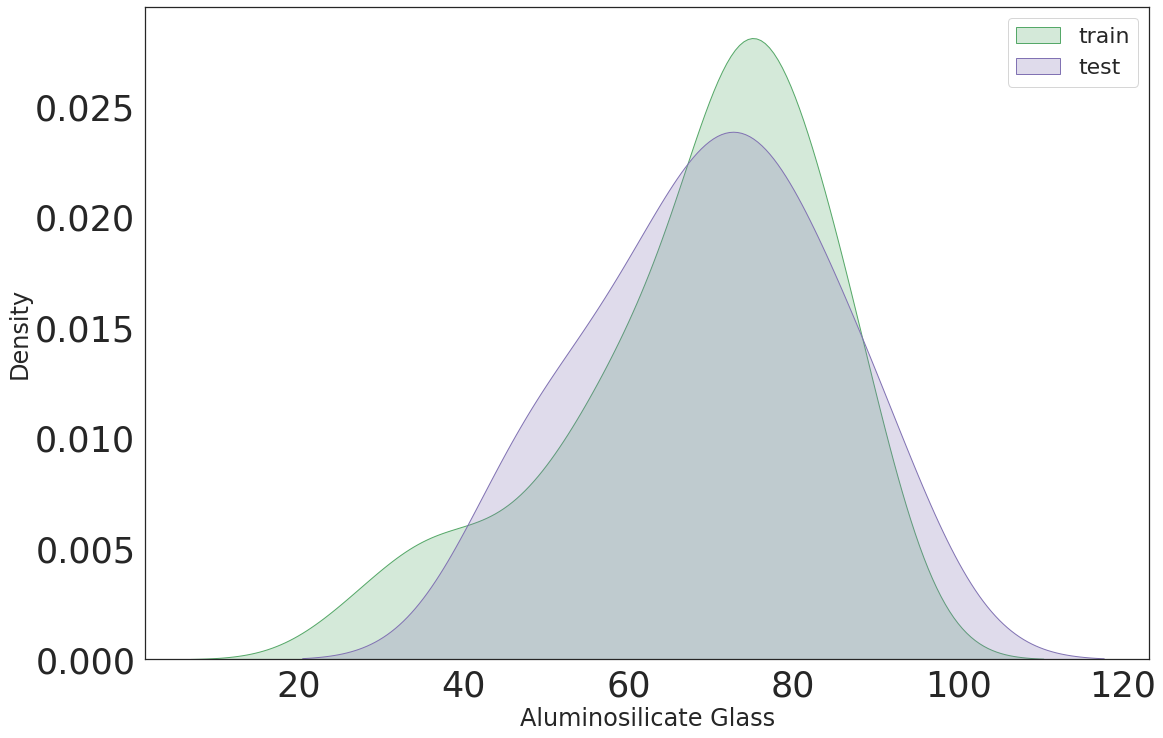

In [74]:
# Stratified Sampling
sns.kdeplot(strat_train['Aluminosilicate Glass'], color="g", fill=True, label="train")
# sns.kdeplot(df.loc[idx_val, col], color="c", fill=True, ax=ax, label="val.")
sns.kdeplot(strat_test['Aluminosilicate Glass'], color="m", fill=True,  label="test")
plt.legend()
# plt.show()

plt.savefig('./stratified_sampling.png')

Comparing to random sampling.

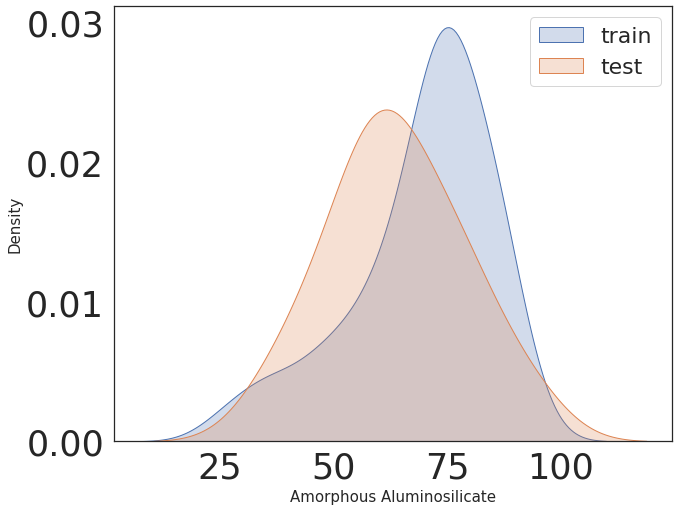

In [75]:
# (vs.) Ordinary Sampling
x_train, x_test, y_train, y_test = train_test_split(df, df['Aluminosilicate Glass'], 
                                                      test_size=0.145, shuffle=True, random_state=42) # stratify=target,
plt.figure(figsize=(10,8))
sns.kdeplot(y_train, fill=True, label="train")
sns.kdeplot(y_test, fill=True,  label="test")
plt.legend()

font = {'size' : 15}
plt.xlabel('Amorphous Aluminosilicate', fontdict=font)
plt.ylabel('Density', fontdict=font)
# plt.show()

plt.savefig('sampling.png')

In [76]:
def amorphous_cat_proportions(data):
    return data["aluminosilicate_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.145, random_state=42)  # 랜덤 샘플링

compare_props = pd.DataFrame({
    "Overall": amorphous_cat_proportions(df),
    "Stratified": amorphous_cat_proportions(strat_test),
    "Random": amorphous_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.211111,0.214286,0.285714,35.338346,1.503759
2,0.188889,0.214286,0.357143,89.075630,13.445378
3,0.211111,0.214286,0.142857,-32.330827,1.503759
4,0.188889,0.142857,0.142857,-24.369748,-24.369748
5,0.200000,0.214286,0.071429,-64.285714,7.142857


In [77]:
for set_ in (strat_train, strat_test):
    set_.drop("aluminosilicate_cat", axis=1, inplace=True)

In [78]:
# # Visualization data 

# df = strat_train.copy()  # 복사본

# import plotly_express as px

# px.scatter_ternary(df,
#                    a="SiO2", b="CaO", c="Al2O3",
#                    color="n_c",
#                    size_max=15,
#                    )

### 4. Data Proprocessing (Feature Scale)

1) Separation of the label from the training set.

In [79]:
flyash = strat_train.iloc[:,0:6]
flyash_labels = strat_train.iloc[:,6]

2) Seperation of the label from the test set.

In [80]:
X_test = strat_test.iloc[:,0:6]
y_test = strat_test.iloc[:,6]

3) Feature Scailing (**Caution: Appling the fit method only to training set.)

In [81]:
flyash_labels = flyash_labels.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [82]:
scalerX = StandardScaler().fit(flyash)
scalery = StandardScaler().fit(flyash_labels)

flyash_scaled = scalerX.transform(flyash)
flyash_labels_scaled = scalery.transform(flyash_labels)

X_test_scaled = scalerX.transform(X_test)
y_test_scaled = scalery.transform(y_test)

In [83]:
# Save scaler
import joblib

joblib.dump(scalerX, "./scalerX.save") 
joblib.dump(scalery, "./scalery.save") 

# # And load...
# scaler = joblib.load(scaler_filename) 

['./scalery.save']

### 5. Select model (ANN)

In [26]:
mlp_model = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(10,3), max_iter=500, alpha=0.1,    # 여기서, max_iter, alpha값은 무의미하다..
                         random_state=42, shuffle=False,
                         validation_fraction=0.18, activation="relu") # .fit(flyash_scaled, flyash_labels_scaled)

### 6. Tune model

#### 1. Exploring hyperparameters, Cross-validation

Error : A column-vector y was passed

In [27]:
flyash_labels_scaled = np.ravel(flyash_labels_scaled)
flyash_scaled = pd.DataFrame(flyash_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'] )
flyash_labels_scaled = pd.Series(flyash_labels_scaled, name='aluminosilicate')

Mini-batch gradient descent

batch_size를 해서.. 모델 성능을 높이기 위해서 입맞에 맞는 데이터만 사용한 것이다.

In [29]:
mlp_model = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(10,3), max_iter=500, alpha=0.1,    # 여기서, max_iter, alpha값은 무의미하다..
                         random_state=42, shuffle=False,
                         validation_fraction=0.18, activation="relu") # .fit(flyash_scaled, flyash_labels_scaled)


iters_num = 685 
train_size = flyash_scaled.shape[0]
batch_size = 65 # mini-batch size

param_grid = [
    # two-step
    {'max_iter': [50, 100, 200, 300, 500, 1000, 2000]},
    {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 10, 100]},
    ]

# 학습률 그래프 그리기 위한 변수 선언
train_r2_list = []
test_r2_list = []

# The number of repetitions per epoch
iter_per_epoch = round(train_size/batch_size)

np.random.seed(42)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)   # 난수를 통해 batch data 샘플링

    flyash_batch = flyash_scaled.iloc[batch_mask,]
    flyash_labels_batch = flyash_labels_scaled.iloc[batch_mask,]

    grid_search = GridSearchCV(mlp_model, param_grid, cv=5,
                             scoring='neg_mean_squared_error',
                             return_train_score=True)
    grid_search.fit(flyash_batch, flyash_labels_batch)        # grid_search 는 batch data로만 진행
    
    
    # # Accuracy per epoch... 전체 train과 test data에서 평가
      
    # model = grid_search.best_estimator_
    # train_predictions = model.predict(flyash_scaled)      
    # test_predictions = model.predict(X_test_scaled)

    # r2_train = r2_score(flyash_labels_scaled, train_predictions)
    # r2_test = r2_score(y_test_scaled, test_predictions)
    
    # train_r2_list.append(r2_train)
    # test_r2_list.append(r2_test)
    # print(i,'번째 iterations, train acc, test acc |', str(r2_train),',',str(r2_test))

In [34]:
# Accuracy per epoch... 전체 train과 test data에서 평가
  
ANN = grid_search.best_estimator_
train_predictions = ANN.predict(flyash_scaled)      
test_predictions = ANN.predict(X_test_scaled)

r2_train = r2_score(flyash_labels_scaled, train_predictions)
r2_test = r2_score(y_test_scaled, test_predictions)

train_r2_list.append(r2_train)
test_r2_list.append(r2_test)
print(i,'번째 iterations, train acc, test acc |', str(r2_train),',',str(r2_test))

684 번째 iterations, train acc, test acc | 0.7462600570973772 , 0.6290867161839766


### 7.Other Model (GBR)

Gradient Boosting (부스팅 앙상블 모델)

In [84]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

In [85]:
def modelfit(alg, performCV=True, print_feature_importances_=True, poly_degree=0, require_return=False):
    if performCV:
      if require_return:
        return stratifiedCV(alg, _degree=poly_degree, return_cv=require_return)

      else:
        stratifiedCV(alg, _degree=poly_degree, return_cv=require_return)
      
    else:
      #Fit the algorithm on the data
      alg.fit(flyash_scaled, flyash_labels_scaled)

      print("train r2_score : ", r2_score(flyash_labels_scaled, alg.predict(flyash_scaled)))
      print("test r2_score : ", r2_score(y_test_scaled, alg.predict(X_test_scaled)))


    #Print Feature Importance:
    if print_feature_importances_:
        feat_imp = pd.Series(alg.feature_importances_, ['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O']).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [86]:
sc_strat_train = pd.DataFrame(flyash_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'])
sc_strat_train['aluminosilicates'] = flyash_labels_scaled
sc_strat_train['aluminosilicate_cat'] = df["aluminosilicate_cat"]

sc_strat_test = pd.DataFrame(X_test_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'])
sc_strat_test['aluminosilicates'] = y_test_scaled

AttributeError: ignored

In [87]:
def stratifiedCV(alg, _degree=0, return_cv=False):   
  # Sampling
  skf = StratifiedKFold(n_splits= 5)  # 5겹 교차검증
  cv_accuracy =[] 


  for part_train_index, valid_index in skf.split(sc_strat_train, sc_strat_train["aluminosilicate_cat"]):   # 레이블 데이터 분포도에 따라 데이터를 분류한다
      part_strat_train = sc_strat_train.loc[part_train_index]
      strat_valid = sc_strat_train.loc[valid_index]

      X_part_train = part_strat_train.iloc[:,0:6]
      y_part_train = pd.DataFrame(part_strat_train.iloc[:,6])

      X_valid = strat_valid.iloc[:,0:6]
      y_valid = pd.DataFrame(strat_valid.iloc[:,6])

      # 확장된 특성을 포함하는, 다항회귀
      if _degree != 0:
        poly = PolynomialFeatures(degree=_degree)   # _degree : 2 이상일 때,

        X_part_train = poly.fit_transform(X_part_train)
        X_valid =poly.fit_transform(X_valid)


      # fitting
      alg.fit(X_part_train, y_part_train)
      pred = alg.predict(X_valid)

      accuracy = np.round(r2_score(y_valid,pred),4)
      cv_accuracy.append(accuracy) 


  print('\n===========================================================================')
  print("CV Score | Mean : %0.4f | Std : %0.4f | Min : %0.4f | Max : %0.4f" % (np.mean(cv_accuracy), np.std(cv_accuracy), 
                                                                              np.min(cv_accuracy), np.max(cv_accuracy)))
  
  if return_cv == True:
    return np.mean(cv_accuracy)
  

In [52]:
default_gbr = GradientBoostingRegressor(random_state=10)
modelfit(default_gbr,print_feature_importances_=False)


CV Score | Mean : 0.0888 | Std : 0.2678 | Min : -0.2340 | Max : 0.4196


In [53]:
default_gbr2 = GradientBoostingRegressor(random_state=10, warm_start=True)
modelfit(default_gbr2, print_feature_importances_=False)


CV Score | Mean : 0.7908 | Std : 0.4085 | Min : -0.0261 | Max : 0.9970


In [88]:
def gbr_early_stopping(alg, degree=0):

  max_val_accuracy = -float("inf")
  error_going_up = 0

  best_n_estimators = None
  best_model = None

  for n_estimators in range(1, 1000):
      alg.n_estimators = n_estimators   # 트리 하나씩 더 생긴다. 

      if degree == 0 :
        val_accuracy = stratifiedCV(alg, return_cv = True)   # val_accuracy는 5겹 검증의 maen값임
      
      else:
        val_accuracy = stratifiedCV(alg, return_cv = True, _degree=degree)


      if val_accuracy > max_val_accuracy: 
          max_val_accuracy = val_accuracy
          error_going_up = 0

          best_n_estimators  = n_estimators
          best_model = deepcopy(alg)

      else:
          error_going_up += 1
          if error_going_up == 50:   # 조기종료 유예
              # 그냥 check code
              print(best_model)
              modelfit(best_model, print_feature_importances_=False, poly_degree=degree)
              print('\n')
              return best_model # early stopping

  return best_model

In [89]:
for i,v in enumerate([1, 0.1, 0.01, 0.001]):
  globals()[f'model{i+1}'] = GradientBoostingRegressor(warm_start=True,  
                                                      learning_rate = v,
                                                      random_state=10)
  
  globals()[f'model{i+1}'] = deepcopy(gbr_early_stopping(globals()[f'model{i+1}']))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
CV Score | Mean : 0.7978 | Std : 0.4000 | Min : -0.0022 | Max : 0.9982



CV Score | Mean : 0.1031 | Std : 0.0571 | Min : 0.0028 | Max : 0.1508

CV Score | Mean : 0.1904 | Std : 0.1057 | Min : 0.0040 | Max : 0.2778

CV Score | Mean : 0.2840 | Std : 0.1317 | Min : 0.0420 | Max : 0.4056

CV Score | Mean : 0.3456 | Std : 0.1623 | Min : 0.0501 | Max : 0.4895

CV Score | Mean : 0.4098 | Std : 0.1811 | Min : 0.0738 | Max : 0.5777

CV Score | Mean : 0.4568 | Std : 0.1911 | Min : 0.1018 | Max : 0.6275

CV Score | Mean : 0.5023 | Std : 0.1996 | Min : 0.1329 | Max : 0.6904

CV Score | Mean : 0.5387 | Std : 0.2100 | Min : 0.1398 | Max : 0.7256

CV Score | Mean : 0.5608 | Std : 0.2287 | Min : 0.1254 | Max : 0.7546

CV Score | Mean : 0.6061 | Std : 0.2174 | Min : 0.1899 | Max : 0.7898

CV Score | Mean : 0.6164 | Std : 0.2305 | Min : 0.1699 | Max : 0.7893

CV Score | Mean : 0.6547 | Std : 0.2211 | Min : 0.2240 | Max : 0.8189

CV Score | Mean : 0.6796 | Std : 0.218

In [90]:
modelfit(model1, print_feature_importances_=False)
print('model1 : ', model1,'\n')
modelfit(model2, print_feature_importances_=False)
print('model2 : ', model2,'\n')
modelfit(model3, print_feature_importances_=False)
print('model3 : ', model3,'\n')
modelfit(model4, print_feature_importances_=False)
print('model4 : ', model4,'\n')


CV Score | Mean : 0.7978 | Std : 0.4000 | Min : -0.0022 | Max : 0.9982
model1 :  GradientBoostingRegressor(learning_rate=1, n_estimators=8, random_state=10,
                          warm_start=True) 



In [91]:
GBR = deepcopy(model1)
modelfit(GBR, performCV=False, print_feature_importances_=False)

train r2_score :  0.8563967388733604
test r2_score :  -0.11830932730910426


Thus, Final model is ANN.

### 8. Evaluation

#### (1) Metrics : R-squared

Final model is ANN

Error : A column-vector y was passed

In [ ]:
# ValueError: Expected 2D array, got 1D array instead:

flyash_labels = flyash_labels.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [ ]:
y_test_scaled = np.ravel(y_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'])

y_test_scaled = pd.DataFrame(y_test_scaled)
flyash_labels_scaled = pd.DataFrame(flyash_labels_scaled)
train_predictions = pd.DataFrame(train_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [ ]:
def mape(y_pred, y):
    return np.mean(np.abs((y_pred - y) / y)) * 100

final_model = grid_search.best_estimator_
train_predictions = final_model.predict(flyash_scaled)
test_predictions = final_model.predict(X_test_scaled)

r2_train = r2_score(flyash_labels_scaled, train_predictions)
r2_test = r2_score(y_test_scaled, test_predictions)

In [ ]:
print("Train set(85%)")
print("R^2", (r2_train))
# print("MAPE", mape(train_predictions, flyash_labels_scaled))
print("========================")
print("Test set(15%)")
print("R^2", (r2_test))
# print("MAPE", mape(test_predictions, y_test_scaled))

Train set(85%)
R^2 0.8122369696008486
Test set(15%)
R^2 0.7739679989077288


#### (2) Feature Importance (모델 해석성)

1. ELI5

In [ ]:
pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(final_model, random_state=42).fit(X_test_scaled, y_test_scaled)   # scoring 파라미터, mlpregressor_gridsearch에서 scoring= 'neg_mean_squared_error' 사용하였기 때문에
explanation = eli5.formatters.as_dataframe.explain_weights_df(perm,feature_names = df.columns[:-2].tolist())
# explanation_pred = eli5.explain_prediction_df(estimator=final_model, doc=X_test_scaled.iloc[0])

In [ ]:
explanation

In [ ]:
eli5.show_weights(perm, feature_names = df.columns[:-2].tolist(),
                  show = ['feature_importances', 'method', 'description'])   # +- std*2

Weight,Feature
7.0316 ± 1.1626,CaO
1.2024 ± 0.7021,MgO
0.5950 ± 0.0631,Al2O3
0.5685 ± 0.3162,SiO2
0.3028 ± 0.2243,Fe2O3
0.0136 ± 0.0813,Na2O+0.658K2O


shuffle 후 모델의 성능 변화를 나타낸다. 

weight가 음수값인 변수들은, shuffle된 데이터가 실제 데이터보다 더 정확한 경우이다. (즉 해당 feature을 제외하니까 모델 성능이 더 좋아진 경우)

2. SHAP

In [ ]:
pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


  0%|          | 0/14 [00:00<?, ?it/s]

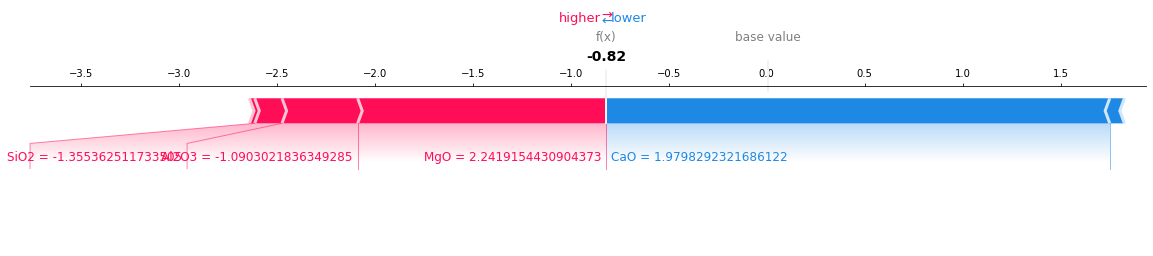

In [ ]:
# shap value 
import shap
import skimage

explainer = shap.KernelExplainer(final_model.predict, flyash_scaled)
shap_values = explainer.shap_values(X_test_scaled)

shap.initjs()
# test set 하나에 대해서 적용
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_scaled.iloc[1,:],
                      show=False, matplotlib=True).savefig('influence_one_of_test.png')

In [ ]:
explainer = shap.TreeExplainer(gbr2)
shap_values = explainer.shap_values(shap_df)
fig=shap.summary_plot(shap_values, shap_df, show=False)
plt.savefig('./shap_plot.png')

Remember that shap values are calculated for each feature and for each record.

In [ ]:
# test set 전체에 대해서 적용
shap.initjs()
fig = shap.force_plot(explainer.expected_value, shap_values, X_test_scaled, show=False)
shap.save_html("influence_test_test.html",fig)

#### (3) Show Graph

Back to before scaling

In [ ]:
flyash_labels_inverse = scalery.inverse_transform(flyash_labels_scaled)
y_test_inverse = scalery.inverse_transform(y_test_scaled)

In [ ]:
train_predictions = train_predictions.reshape(-1,1)
test_predictions = test_predictions.reshape(-1,1)

In [ ]:
train_predictions_inverse = scalery.inverse_transform(train_predictions)
test_predictions_inverse = scalery.inverse_transform(test_predictions)

Graph

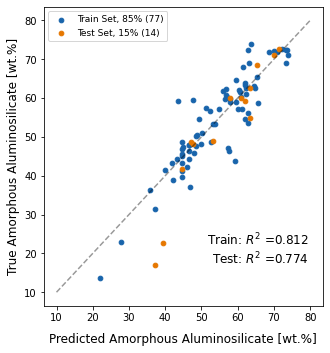

In [ ]:
fig, ax = plt.subplots(figsize=(5,5.5))
ax.scatter(train_predictions_inverse, flyash_labels_inverse, color='#1864AB', label='Train Set, 85% (77)', s=22)
ax.scatter(test_predictions_inverse, y_test_inverse, color='#E67700', label='Test Set, 15% (14)', s=22)

# y=x dashed line
ax.plot([10,80], [10,80], c="k", linestyle='--',alpha=0.4)

font = {'size':12}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=4, fontdict=font)
ax.legend(fontsize=9, loc="upper left")


ax.text(0.95, 0.14, f"Train: $R^2$ ={r2_train:0.3f}\nTest: $R^2$ ={r2_test:0.3f}",
        transform=ax.transAxes, fontsize=12, ha="right")

    
fig.savefig(f"./performence_foreign model.png")

### 9. Apply New data (Korean flyashes)

Apply Korean Data

In [ ]:
df = pd.read_csv('./flyash.csv')
df.drop('ID', axis=1, inplace=True)
df.drop('LOI', axis=1, inplace=True)
df.drop('Amorphous Alumina', axis=1, inplace=True)
df.drop('Amorphous Silica', axis=1, inplace=True)
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,Sum of amorphous aluminosilicates
0,20.9,2.7,5.2,64.8,1.4,1.7,60.00
1,20.8,2.7,5.0,65.0,1.4,1.8,58.00
2,20.9,5.7,8.2,55.9,2.0,2.4,60.00
3,21.3,4.0,6.4,59.5,1.5,1.2,44.00
4,20.1,4.1,8.7,58.8,2.0,1.8,52.00
...,...,...,...,...,...,...,...
57,22.9,5.5,7.7,55.9,1.8,2.2,55.20
58,21.2,3.9,6.3,62.7,1.5,0.8,66.70
59,22.9,6.4,9.0,52.0,1.8,2.9,53.92
60,20.1,3.4,5.6,53.7,0.9,1.9,48.58


Check performance

In [ ]:
X_korean = df.iloc[:,0:6]
y_korean = df.iloc[:,6]

## Scailing data
y_korean = y_korean.values.reshape(-1,1)

X_korean_scaled = scalerX.transform(X_korean)
y_korean_scaled = scalery.transform(y_korean)

## Predict data
korean_predictions = final_model.predict(X_korean_scaled)
r2_value = r2_score(y_korean_scaled,korean_predictions)
r2_value

-2.1654886877422133

Combine graphs

In [ ]:
# ValueError: Expected 2D array, got 1D array instead:

korean_predictions = pd.DataFrame(korean_predictions)

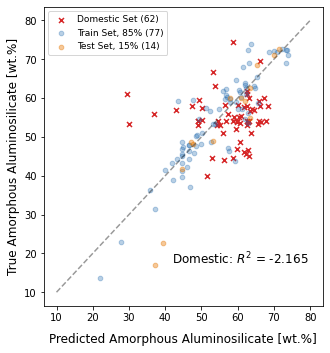

In [ ]:
## Return before scailing
y_korean_inverse = scalery.inverse_transform(y_korean_scaled)
korean_predictions_inverse = scalery.inverse_transform(korean_predictions)

## Figure
fig, ax = plt.subplots(figsize=(5, 5.5))
ax.scatter(korean_predictions_inverse, y_korean_inverse, color='C3', label='Domestic Set (62)', s = 25, marker = 'x')  # koeran flyash
ax.scatter(train_predictions_inverse, flyash_labels_inverse, color='#1864AB', label='Train Set, 85% (77)', s=22, alpha=0.3)     # train data
ax.scatter(test_predictions_inverse, y_test_inverse, color='#E67700', label='Test Set, 15% (14)', s=22, alpha=0.4)              # test data

ax.plot([10,80], [10,80], c="k", linestyle='--',alpha=0.4) # y=x dashed line

font = { 'size' : 12}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=4, fontdict=font)
ax.legend(fontsize=9,loc="upper left")

# $Test: R^2 ={r2_test:0.3f}$
ax.text(0.95, 0.14, f"\nDomestic: $R^2$ = {r2_value:0.3f}", 
        transform=ax.transAxes, fontsize=12, ha="right")

fig.savefig(f"./performance_plus domestic.png")